Import Library

In [21]:
import os
import cv2
import numpy as np
from tabulate import tabulate
from sklearn import preprocessing
from skimage.feature import graycomatrix, graycoprops

Directory

In [22]:
image_directory_training="../Dataset/preprocessed_roi_augmentation/2_label/dataset_training"
image_directory_testing="../Dataset/preprocessed_roi_augmentation/2_label/dataset_testing"

GLCM Atribut

In [23]:
#scenario GLCM properties
# glcm_properties = ['dissimilarity', 'correlation', 'homogeneity']
# glcm_properties = ['dissimilarity', 'correlation', 'contrast']
# glcm_properties = ['dissimilarity', 'homogeneity', 'contrast']
# glcm_properties = ['correlation', 'homogeneity', 'contrast']
glcm_properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast']
angles = [0, 45, 90, 135]
distance = [5]

Inisialisasi Property Histogram

In [24]:
bins = 16

Ekstraksi Fitur HSV + GLCM

In [25]:
def ef_hsv_glcm_training(image_directory_training):

    # membuat list untuk menyimpan hasil ekstraksi fitur
    features_training = []

    # melakukan ekstraksi fitur pada setiap folder
    for a, (root, dirs, files) in enumerate(os.walk(image_directory_training), start=0):

        # mengambil semua file gambar di dalam folder
        image_files = [f for f in files if f.endswith('.jpg')]

        # melakukan ekstraksi fitur pada setiap gambar
        for image_file in image_files:
            # membaca gambar
            image = cv2.imread(os.path.join(root, image_file))

            # Konversi gambar ke ruang warna HSV
            hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

            h, s, v = cv2.split(hsv_image)  # Pisahkan channel H, S, dan V

            # Hitung histogram untuk channel H
            hist_h = cv2.calcHist([h], [0], None, [bins], [0, 256])
            hist_h = np.ravel(hist_h)  # Mengubah histogram H menjadi array 1 dimensi

            # Hitung histogram untuk channel S
            hist_s = cv2.calcHist([s], [0], None, [bins], [0, 256])
            hist_s = np.ravel(hist_s)  # Mengubah histogram S menjadi array 1 dimensi

            # Hitung histogram untuk channel V
            hist_v = cv2.calcHist([v], [0], None, [bins], [0, 256])
            hist_v = np.ravel(hist_v)  # Mengubah histogram V menjadi array 1 dimensi

            # Hitung matriks glcm
            image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            glcm = graycomatrix(image_gray, distances=distance, angles=[
                                0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)

            # Hitung fitur glcm
            feature_glcm = []
            glcm_props = [
                propery for name in glcm_properties for propery in graycoprops(glcm, name)[0]]
            for item in glcm_props:
                feature_glcm.append(item)

            #menambahkan semua fitur ke list
            features_training.append([*hist_h, *hist_s, *hist_v] + feature_glcm + [a])

    return features_training


def ef_hsv_glcm_testing(image_directory_testing):

    # membuat list untuk menyimpan hasil ekstraksi fitur
    features_testing = []

    # melakukan ekstraksi fitur pada setiap folder
    for a, (root, dirs, files) in enumerate(os.walk(image_directory_testing), start=0):

        # mengambil semua file gambar di dalam folder
        image_files = [f for f in files if f.endswith('.jpg')]

        # melakukan ekstraksi fitur pada setiap gambar
        for image_file in image_files:
            # membaca gambar
            image = cv2.imread(os.path.join(root, image_file))

            # Konversi gambar ke ruang warna HSV
            hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

            h, s, v = cv2.split(hsv_image)  # Pisahkan channel H, S, dan V

            # Hitung histogram untuk channel H
            hist_h = cv2.calcHist([h], [0], None, [bins], [0, 256])
            # Mengubah histogram H menjadi array 1 dimensi
            hist_h = np.ravel(hist_h)

            # Hitung histogram untuk channel S
            hist_s = cv2.calcHist([s], [0], None, [bins], [0, 256])
            # Mengubah histogram S menjadi array 1 dimensi
            hist_s = np.ravel(hist_s)

            # Hitung histogram untuk channel V
            hist_v = cv2.calcHist([v], [0], None, [bins], [0, 256])
            # Mengubah histogram V menjadi array 1 dimensi
            hist_v = np.ravel(hist_v)
            
            # Hitung matriks glcm
            image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            glcm = graycomatrix(image_gray, distances=distance, angles=[
                                0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)

            # Hitung fitur glcm
            feature_glcm = []
            glcm_props = [
                propery for name in glcm_properties for propery in graycoprops(glcm, name)[0]]
            for item in glcm_props:
                feature_glcm.append(item)

            #menambahkan semua fitur ke list
            features_testing.append([*hist_h, *hist_s, *hist_v] + feature_glcm + [a])

    return features_testing


Inisialisasi Data Training

In [26]:
#NORMALISASI DATA 
extraction_feature = ef_hsv_glcm_training(image_directory_training)
data = [data[:-1] for data in extraction_feature]
label = [data[-1] for data in extraction_feature]

normalization_data = preprocessing.normalize(data, norm="l2")

# Menggabungkan data dan label
train_data = []
for data, label in zip(normalization_data, label):
    # Mengambil nilai fitur berdasarkan indeks
    feature_values = [data[i] for i in range(len(data))]
    result_row = feature_values + [label]
    train_data.append(result_row)

In [27]:
# train_data = ef_hsv_glcm_training(image_directory_training)

In [28]:
# header tabel hsv glcm
header = ['hist_h' + str(i+1) for i in range(bins)] + ['hist_s' + str(i+1) for i in range(bins)] + ['hist_v' + str(i+1) for i in range(bins)] + [f'{prop} {angle}' for prop in glcm_properties for angle in angles] + ["Label"]

# Mencetak tabel menggunakan tabulate
print(tabulate(train_data, headers=header, tablefmt="grid"))

+-----------+------------+-----------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+------------+------------+------------+------------+-----------+------------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+------------+------------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+------------+------------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+------------+-------------------+--------------------+--------------------+---------------------+-----------------+------------------+------------------+-------------------+-----------------+------------------+------------------+-------------------+--------------+---------------+---------------+----------------+---------+
|   hist_h1 |    hist_h2 |   hist_h3

Inisialisasi Data Testing

In [29]:
#NORMALISASI DATA
extraction_feature = ef_hsv_glcm_testing(image_directory_testing)
data = [data[:-1] for data in extraction_feature]
label = [data[-1] for data in extraction_feature]

normalization_data = preprocessing.normalize(data, norm="l2")

# Menggabungkan data dan label
test_data = []
for data, label in zip(normalization_data, label):
    # Mengambil nilai fitur berdasarkan indeks
    feature_values = [data[i] for i in range(len(data))]
    result_row = feature_values + [label]
    test_data.append(result_row)

In [30]:
# test_data = ef_hsv_glcm_testing(image_directory_testing)

In [31]:
# header tabel hsv glcm
header = ['hist_h' + str(i+1) for i in range(bins)] + ['hist_s' + str(i+1) for i in range(bins)] + ['hist_v' + str(i+1) for i in range(bins)] + [f'{prop} {angle}' for prop in glcm_properties for angle in angles] + ["Label"]

# Mencetak tabel menggunakan tabulate
print(tabulate(test_data, headers=header, tablefmt="grid"))

+-----------+------------+-----------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+------------+------------+------------+------------+-----------+------------+------------+------------+-------------+-------------+-------------+-------------+-------------+------------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+------------+-----------+-----------+------------+------------+------------+-------------+-------------+-------------+-------------+------------+------------+-------------------+--------------------+--------------------+---------------------+-----------------+------------------+------------------+-------------------+-----------------+------------------+------------------+-------------------+--------------+---------------+---------------+----------------+---------+
|   hist_h1 |    hist_h2 |   hist_h3 |    h

Klasifikasi Model Naive Bayes

In [32]:
X_train = [data[:-1] for data in train_data]
y_train = [data[-1] for data in train_data ]

In [33]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [34]:
X_test = [data[:-1] for data in test_data]
y_true = [data[-1] for data in test_data]

In [35]:
y_pred = model.predict(X_test)
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2])

In [36]:
# Menggabungkan data uji dan hasil prediksi
result_table = []
for data, pred in zip(test_data, y_pred):
    # Mengambil nilai fitur berdasarkan indeks
    feature_values = [data[i] for i in range(len(data))]
    result_row = feature_values + [pred]
    result_table.append(result_row)

# header tabel hsv glcm
header = ['hist_h' + str(i+1) for i in range(bins)] + ['hist_s' + str(i+1) for i in range(bins)] + ['hist_v' + str(i+1) for i in range(bins)] + [f'{prop} {angle}' for prop in glcm_properties for angle in angles] + ["True Label", "Predict Label"]

# Mencetak tabel menggunakan tabulate
print(tabulate(result_table, headers=header, tablefmt="grid"))


+-----------+------------+-----------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+------------+------------+------------+------------+-----------+------------+------------+------------+-------------+-------------+-------------+-------------+-------------+------------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+------------+-----------+-----------+------------+------------+------------+-------------+-------------+-------------+-------------+------------+------------+-------------------+--------------------+--------------------+---------------------+-----------------+------------------+------------------+-------------------+-----------------+------------------+------------------+-------------------+--------------+---------------+---------------+----------------+--------------+-----------------+
|   hist_h1 |    his

In [37]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.97      1.00      0.98        32
           2       1.00      0.97      0.98        32

    accuracy                           0.98        64
   macro avg       0.98      0.98      0.98        64
weighted avg       0.98      0.98      0.98        64



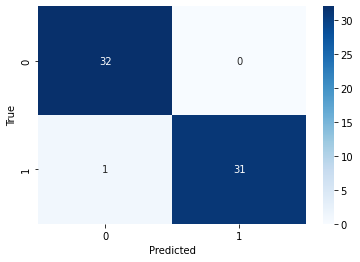

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# menghitung confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [39]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.984375


Export Model

In [40]:
# import joblib

# # simpan model dalam file .pkl
# joblib.dump(
#     model, '../Model/NB_HSV[Hist-16]_GLCM[S5-D5]_160_ROI_2Label.pkl')